In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore');
import os
import sys

In [2]:
# # Alternate Dataset for test purposes. Not used in the example shown
# # Importing our dataset
# os.chdir("C:/Users/Hilak/Desktop/INTERESTS/Machine Learning A-Z Template Folder/Part 3 - Classification/Section 14 - Logistic Regression");
# training_set = pd.read_csv("Social_Network_Ads.csv");

# # Splitting our dataset into matrix of features and output values.
# X = training_set.iloc[:, 1:4].values
# y = training_set.iloc[:, 4].values

# # Encoding our object features.
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# le_x = LabelEncoder()
# X[:,0] = le_x.fit_transform(X[:,0])
# ohe = OneHotEncoder(categorical_features = [0])
# X = ohe.fit_transform(X).toarray()

# # Performing Feature scaling
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# X[:,2:4] = ss.fit_transform(X[:, 2:4])

# # Splitting the dataset into train and test set.
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
# X_train = X_train.T
# X_test = X_test.T

<big><b>This dataset contains the click of a user on an advertisement of a new brand car</b></big>.<br> 
The dataset has the following features:
1. User ID.
2. Gender.
3. Age.
4. Estimated Saalry.
5. Purchsed - Boolean indicating if the user bought the car.

<br>
<b>Size of the dataset : 400</b>
<br>
Except User ID, we will be keeping all the features to train our neural network. Although, during EDA, it has been found that "estimated salary" causes some overfitting. So, it would be a good dataset to make our model more robust so it deals with similar situation by itself.

In [3]:
os.chdir("C:\\Users\\Hilak\\Desktop\\INTERESTS\\Machine Learning A-Z Template Folder\\Part 8 - Deep Learning\\Section 39 - Artificial Neural Networks (ANN)");
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, [13]].values

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

<br>Problem statement: This dataset contains the data of customers of a bank. The bank has hired you as a data scientist to predict if the customer will stay with the bank or leave.<br><br>
<strong>Total no. of examples in the dataset     : 10000</strong><br>
<strong>No. of examples in the training set      : 8000</strong><br>
<strong>No. of examples in the test set          : 1000</strong><br>
<strong>No. of examples in the CV set            : 1000</strong><br><br>

In [4]:
def sigmoid(z) :
    """ Reutrns the element wise sigmoid function. """
    return 1./(1 + np.exp(-z))
def sigmoid_prime(z) :
    """ Returns the derivative of the sigmoid function. """
    return sigmoid(z)*(1-sigmoid(z))
def ReLU(z) : 
    """ Reutrns the element wise ReLU function. """
    return (z*(z > 0))
def ReLU_prime(z) :
    """ Returns the derivative of the ReLU function. """
    return 1*(z>=0)
def lReLU(z) : 
    """ Reutrns the element wise leaky ReLU function. """
    return np.maximum(z/100,z)
def lReLU_prime(z) :
    """ Returns the derivative of the leaky ReLU function. """
    z = 1*(z>=0)
    z[z==0] = 1/100
    return z
def tanh(z) :
    """ Reutrns the element wise hyperbolic tangent function. """
    return np.tanh(z)
def tanh_prime(z) : 
    """ Returns the derivative of the tanh function. """
    return (1-tanh(z)**2)

# A dictionary of our activation functions
PHI = {'sigmoid':sigmoid, 'relu':ReLU, 'lrelu':lReLU, 'tanh':tanh}

# A dictionary containing the derivatives of our activation functions
PHI_PRIME = {'sigmoid':sigmoid_prime, 'relu':ReLU_prime, 'lrelu':lReLU_prime, 'tanh':tanh_prime}


class NeuralNet : 
    """
    This is a class for implementing Artificial Neural Networks. L2 and Droupout are the 
    default regularization methods implemented in this class. It takes the following parameters:
    
    1. layers      : A python list containing the different number of neurons in each layer.
                     (containing the output layer)
                     Eg - [64,32,16,16,1]
                
    2. X           : Matrix of features with rows as features and columns as different examples.
    
    3. y           : Numpy array containing the ouputs of coresponding examples.
    
    4. ac_funcs    : A python list containing activation function of each layer.
                     Eg - ['relu','relu','lrelu','tanh','sigmoid']
    
    5. init_method : Meathod to initialize weights of the network. Can be 'gaussian','random','zeros'.
    
    6. loss_func   : Currently not implemented
    
    7. W           : Weights of a pretrained neural network with same architecture.
    
    8. B           : Biases of a pretrained neural network with same architecture.
    """
    def __init__(self, layers, X, y, ac_funcs, init_method='gaussian', loss_func='b_ce', W=np.array([]), B=np.array([])) :
        """ Initialize the network. """
        # Store the layers of the network
        self.layers = layers
        # ----
        self.W = None
        self.B = None
        # Store the number of examples in the dataset as m
        self.m = X.shape[1]
        # Store the full layer list as n
        self.n = [X.shape[0], *layers]
        # Save the dataset
        self.X = X
        # Save coresponding output
        self.y = y
        self.X_mini = None
        self.y_mini = None
        self.m_mini = None
        # List to store the cost of the model calculated during training
        self.cost = []
        # Stores the accuracy obtained on the test set.
        self.acc = 0
        # Activation function of each layer
        self.ac_funcs = ac_funcs
        self.loss = loss_func
        # Initialize the weights by provided method.
        if len(W) and len(B) :
            self.W = W
            self.B = B
        else : 
            if init_method=='gaussian': 
                self.W = [np.random.randn(self.n[nl], self.n[nl-1])*np.sqrt(2/self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
            elif init_method == 'random':
                self.W = [np.random.rand(self.n[nl], self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.random.rand(nl,1) for nl in self.layers]
            elif init_method == 'zeros':
                self.W = [np.zeros((self.n[nl], self.n[nl-1]), 'float32') for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
        self.vdw = [np.zeros(i.shape) for i in self.W]
        self.vdb = [np.zeros(i.shape) for i in self.B]
        self.sdw = [np.zeros(i.shape) for i in self.W]
        self.sdb = [np.zeros(i.shape) for i in self.B]
    
    def startTraining(self, batch_size, epochs, alpha, decay_rate, beta1, beta2, _lambda, keep_prob=0.5, interval=10):
        """
        Start training the neural network. It takes the followng parameters : 
        
        1. batch_size : Size of your mini batch. Must be greater than 1.
        
        2. epochs     : Number of epochs for which you want to train the network.
        
        3. alpha      : The learning rate of your network.
        
        4. decay_rate : The rate at which you want to decrease your learning rate.
        
        4. beta1      : Momentum
        
        5. beta2      : RMSprop Parameter
        
        6. _lambda    : L2 regularization parameter or the penalization parameter.
        
        7. keep_prob  : Dropout regularization parameter. The percentage of neurons to keep activated.
                        Eg - 0.8 means 20% of the neurons have been deactivated.
        
        8. interval   : The interval between updates of cost and accuracy.
        """
        dataset_size = self.X.shape[1]
        k=1
        cost_val = 0
        for j in range(1, epochs+1):
            start = time.time()
            alpha = alpha/( 1 + decay_rate*(j-1) )
            for i in range(0, dataset_size-batch_size+1, batch_size):
                self.X_mini = self.X[:, i:i+batch_size]
                self.y_mini = self.y[:, i:i+batch_size]
                self.m_mini = self.y_mini.shape[1]
                self._miniBatchTraining(alpha, beta1, beta2, _lambda, keep_prob,k)
                aa = self.predict(self.X)
                if not k%interval:
                    if self.loss == 'b_ce':
                        aa_ = aa > 0.5
                        self.acc = np.sum(aa_ == self.y) / self.m
                        cost_val = self._cost_func(aa, _lambda)
                        self.cost.append(cost_val)
                    elif self.loss == 'c_ce':
                        aa_ = np.argmax(aa, axis = 0)
                        yy = np.argmax(self.y, axis = 0)
                        self.acc = np.sum(aa_==yy)/(self.m)
                        cost_val = self._cost_func(aa, _lambda)
                        self.cost.append(cost_val)
                sys.stdout.write(f'\rEpoch[{j}] {i+batch_size}/{self.m} : Cost = {cost_val:.4f} ; Acc = {(self.acc*100):.2f}% ; Time Taken = {(time.time()-start):.0f}s')
                k+=1
            print("\n")
        
    
    def _miniBatchTraining(self, alpha, beta1, beta2, _lambda, keep_prob,i):
        epsilon = 1e-8
        z,a = self._feedForward(keep_prob)
        delta = self._cost_derivative(a[-1])
        for l in range(1,len(z)) : 
            delta_w = (1/self.m_mini)*(np.dot(delta, a[-l-1].T) + (_lambda)*self.W[-l])
            delta_b = (1/self.m_mini)*(np.sum(delta, axis=1, keepdims=True))
            self.vdw[-l] = (beta1*self.vdw[-l] + (1-beta1)*delta_w)
            vdw_corrected = self.vdw[-l]/(1 - beta1**i)
            self.vdb[-l] = (beta1*self.vdb[-l] + (1-beta1)*delta_b)
            vdb_corrected = self.vdb[-l]/(1 - beta1**i)
            self.sdw[-l] = (beta2*self.sdw[-l] + (1-beta2)*(delta_w**2))
            sdw_corrected = self.sdw[-l]/(1 - beta2**i)
            self.sdb[-l] = (beta2*self.sdb[-l] + (1-beta2)*(delta_b**2))
            sdb_corrected = self.sdb[-l]/(1 - beta2**i)
            delta = np.dot(self.W[-l].T, delta)*PHI_PRIME[self.ac_funcs[-l-1]](z[-l-1])
            self.W[-l] = self.W[-l] - (alpha)*(vdw_corrected/(np.sqrt(sdw_corrected)+epsilon))
            self.B[-l] = self.B[-l] - (alpha)*(vdb_corrected/(np.sqrt(sdb_corrected)+epsilon))
        delta_w = (1/self.m_mini)*(np.dot(delta, self.X_mini.T ) + (_lambda)*self.W[0])
        delta_b = (1/self.m_mini)*(np.sum(delta, axis=1, keepdims=True))
        self.vdw[0] = (beta1*self.vdw[0] + (1-beta1)*delta_w)
        vdw_corrected = self.vdw[0]/(1 - beta1**i)
        self.vdb[0] = (beta1*self.vdb[0] + (1-beta1)*delta_b)
        vdb_corrected = self.vdb[0]/(1 - beta1**i)
        self.sdw[0] = (beta2*self.sdw[0] + (1-beta2)*(delta_w**2))
        sdw_corrected = self.sdw[0]/(1 - beta2**i)
        self.sdb[0] = (beta2*self.sdb[0] + (1-beta2)*(delta_b**2))
        sdb_corrected = self.sdb[0]/(1 - beta2**i)
        self.W[0] = self.W[0] - (alpha)*(vdw_corrected/(np.sqrt(sdw_corrected)+epsilon))
        self.B[0] = self.B[0] - (alpha)*(vdb_corrected/(np.sqrt(sdb_corrected)+epsilon))
        return None
    
    def predict(self, X_test) :
        """ Predict the labels for a new dataset. Returns probability. """
        a = PHI[self.ac_funcs[0]](np.dot(self.W[0], X_test) + self.B[0])
        for l in range(1,len(self.layers)):
            a = PHI[self.ac_funcs[l]](np.dot(self.W[l], a) + self.B[l])
        return a
            
    
    def _feedForward(self, keep_prob):
        """ Forward pass """
        z = [];a = []
        z.append(np.dot(self.W[0], self.X_mini) + self.B[0])
        a.append(PHI[self.ac_funcs[0]](z[-1]))
        for l in range(1,len(self.layers)-1):
            z.append(np.dot(self.W[l], a[-1]) + self.B[l])
            # a.append(PHI[self.ac_funcs[l]](z[l]))
            _a = PHI[self.ac_funcs[l]](z[l])
            a.append( ((np.random.rand(*_a.shape) < keep_prob)*_a)/keep_prob )
        z.append(np.dot(self.W[-1], a[-1]) + self.B[-1])
        a.append(PHI[self.ac_funcs[-1]](z[-1]))
        return z,a
    
    def _cost_func(self, a, _lambda):
        """ Binary Cross Entropy Cost Function """
        return ( (-1/self.m)*np.sum(np.nan_to_num(self.y*np.log(a) + (1-self.y)*np.log(1-a))) + (_lambda/(2*self.m))*np.sum([np.sum(i**2) for i in self.W]) )

    def _cost_derivative(self, a) : 
        """ The derivative of cost w.r.t z """
        return (a-self.y_mini)
   
    @property
    def summary(self) :
        return self.cost, self.acc, self.W,self.B
    def __repr__(self) : 
        return f'<Neural Network at {id(self)}>'

In [5]:
# Initializing our neural network
neural_net_sigmoid = NeuralNet([16,16,1], X_train, y_train, ac_funcs = ['relu','relu','sigmoid'])
# Staring the training of our network.
neural_net_sigmoid.startTraining(batch_size=500, epochs=100, alpha=0.02, decay_rate=0.0005, beta1=0.9, beta2=0.999, _lambda=0.5, keep_prob=0.86, interval=10)
# Predicting on new dataset using our trained network.
preds = neural_net_sigmoid.predict(X_test)
preds = preds > 0.5
acc = (sum(sum(preds == y_test)) / y_test.size)*100
# Accuracy (metric of evaluation) obtained by the network.
print(f'Test set Accuracy : {acc}%')

Epoch[1] 8000/8000 : Cost = 0.4702 ; Acc = 79.51% ; Time Taken = 0s

Epoch[2] 8000/8000 : Cost = 0.4048 ; Acc = 83.14% ; Time Taken = 0s

Epoch[3] 8000/8000 : Cost = 0.3807 ; Acc = 84.67% ; Time Taken = 0s

Epoch[4] 8000/8000 : Cost = 0.3546 ; Acc = 85.41% ; Time Taken = 0s

Epoch[5] 8000/8000 : Cost = 0.3438 ; Acc = 85.90% ; Time Taken = 0s

Epoch[6] 8000/8000 : Cost = 0.3442 ; Acc = 86.11% ; Time Taken = 0s

Epoch[7] 8000/8000 : Cost = 0.3395 ; Acc = 86.21% ; Time Taken = 0s

Epoch[8] 8000/8000 : Cost = 0.3388 ; Acc = 86.31% ; Time Taken = 0s

Epoch[9] 8000/8000 : Cost = 0.3385 ; Acc = 86.22% ; Time Taken = 0s

Epoch[10] 8000/8000 : Cost = 0.3358 ; Acc = 86.29% ; Time Taken = 0s

Epoch[11] 8000/8000 : Cost = 0.3371 ; Acc = 86.30% ; Time Taken = 0s

Epoch[12] 8000/8000 : Cost = 0.3333 ; Acc = 86.48% ; Time Taken = 0s

Epoch[13] 8000/8000 : Cost = 0.3326 ; Acc = 86.35% ; Time Taken = 0s

Epoch[14] 8000/8000 : Cost = 0.3337 ; Acc = 86.52% ; Time Taken = 0s

Epoch[15] 8000/8000 : Cost = 

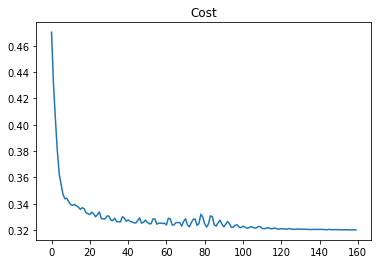

In [6]:
# Plotting our cost vs epochs relationship
sigmoid_summary = neural_net_sigmoid.summary
plt.plot(range(len(sigmoid_summary[0])), sigmoid_summary[0], label='Sigmoid Cost')
plt.title('Cost')
plt.show()

In [7]:
# Comparing our results with the library keras.
from keras.models import Sequential
from keras.layers import Dense
X_train, X_test,y_train,y_test = X_train.T, X_test.T,y_train.T, y_test.T
classifier = Sequential()
classifier.add(Dense(input_dim=11, units = 16, kernel_initializer="uniform", activation="relu"))
classifier.add(Dense(units = 16, kernel_initializer = "uniform", activation="relu"))
# classifier.add(Dense(units = 16, kernel_initializer = "uniform", activation="tanh"))
classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid"))
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(X_train, y_train, batch_size = 500, epochs = 100)
y_pred = classifier.predict(X_test)
y_pred = 1*(y_pred > 0.5)
test_acc = sum(sum(y_pred == y_test)) / y_test.size
print(f"Test set Accuracy : {test_acc*100}%")
X_train, X_test,y_train,y_test = X_train.T, X_test.T,y_train.T, y_test.T

Using TensorFlow backend.


Epoch 1/100
8000/8000 [==============================] - 1s 68us/step - loss: 0.6892 - acc: 0.7933
Epoch 2/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.6767 - acc: 0.7956
Epoch 3/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.6525 - acc: 0.7956
Epoch 4/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.6090 - acc: 0.7956
Epoch 5/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.5482 - acc: 0.7956
Epoch 6/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.4904 - acc: 0.7956
Epoch 7/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.4566 - acc: 0.7956
Epoch 8/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.4452 - acc: 0.7956
Epoch 9/100
8000/8000 [==============================] - 0s 8us/step - loss: 0.4406 - acc: 0.7956
Epoch 10/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.4377 - acc: 0.7956
Epoch 11/100
8000/

8000/8000 [==============================] - 0s 6us/step - loss: 0.3890 - acc: 0.8400
Epoch 84/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.3888 - acc: 0.8390
Epoch 85/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.3884 - acc: 0.8401
Epoch 86/100
8000/8000 [==============================] - 0s 9us/step - loss: 0.3884 - acc: 0.8401
Epoch 87/100
8000/8000 [==============================] - 0s 8us/step - loss: 0.3882 - acc: 0.8403
Epoch 88/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.3881 - acc: 0.8406
Epoch 89/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.3879 - acc: 0.8399
Epoch 90/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.3879 - acc: 0.8409
Epoch 91/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.3877 - acc: 0.8411
Epoch 92/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.3877 - acc: 0.8401
Epoch 93/100
8000/8000 